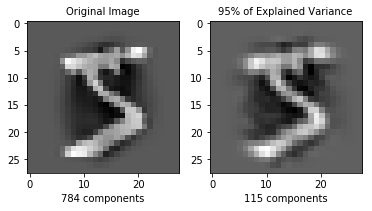

In [1]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from sklearn import metrics
import time

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import time
x = reduced_data
y = label
X_tr = reduced_data
Y_tr = label

In [3]:
ob_error = []
number_of_trees = [1,5,10,50,100,200,500]
for N_estimators in number_of_trees:
    tree = DecisionTreeClassifier()
    bag = BaggingClassifier(tree, n_estimators=N_estimators, oob_score=True, max_samples=0.8, random_state=42)
    bagging = bag.fit(X_tr, Y_tr)
    #print("Total time consumed is %s seconds : " % (time.time() - start_time))
    oob_error = 1 - bagging.oob_score_
    ob_error = ob_error + [oob_error]
    #print(ob_error)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:606: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:611: RuntimeWarning: divide by zero encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:611: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:606: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:611: RuntimeWarning: divide by zero encountered in true_divide
  predictions.sum

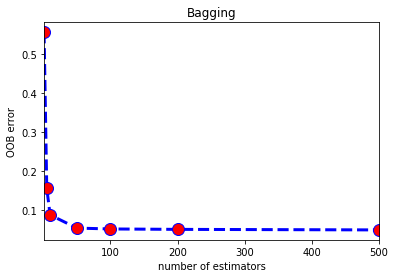

In [4]:
plt.plot(number_of_trees, ob_error, color='blue', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='red', markersize=12)
plt.title("Bagging")
plt.xlim(1, 500)
plt.xlabel("number of estimators")
plt.ylabel("OOB error")
plt.show()

In [5]:
error = oob_error
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  95.08 %
Error Percentage      :  4.92 %


In [ ]:
#Random Forest Algorithm

In [6]:
ob_error = []
number_of_trees = [1,5,10,50,100,200,500]
for N_estimators in number_of_trees :
    #start_time = time.time()
    clf = RandomForestClassifier(n_estimators=N_estimators,warm_start = True, oob_score =True, random_state = 42)
    clf = clf.fit(X_tr, Y_tr)
    #print("Total time consumed is %s seconds : " % (time.time() - start_time))
    oob_error = 1 - clf.oob_score_
    ob_error = ob_error + [oob_error]
    #print(ob_error)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=

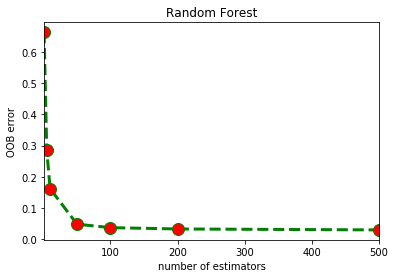

In [7]:
plt.plot(number_of_trees, ob_error, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='red', markersize=12)
#plt.plot(N_estimators, oob_error, label=label)
plt.title("Random Forest")
plt.xlim(1, 500)
plt.xlabel("number of estimators")
plt.ylabel("OOB error")
plt.show()

In [8]:
error = oob_error
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  97.03 %
Error Percentage      :  2.97 %


In [ ]:
#Calculation of time for Bagging

In [9]:
start_time = time.time()
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=200, oob_score=True, max_samples=0.8, random_state=42)
bagging = bag.fit(X_tr, Y_tr)
X_test = reduced_test_data
predictionsY_test = bagging.predict(X_test)
print("Total time consumed is %s seconds : " % (time.time() - start_time))

Total time consumed is 1898.4705202579498 seconds : 


In [10]:
error = 1 - bagging.oob_score_
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  94.94 %
Error Percentage      :  5.06 %


In [11]:
display(predictionsY_test)

array([7., 2., 1., ..., 4., 5., 6.])

In [ ]:
#Calculation of time for RF

In [12]:
start_time = time.time()
clf = RandomForestClassifier(n_estimators=200,warm_start = True, oob_score =True, random_state = 42, 
                             max_features="sqrt")
clf = clf.fit(X_tr, Y_tr)

X_test = reduced_test_data
predictionsY_test = clf.predict(X_test)
print("Total time consumed is %s seconds : " % (time.time() - start_time))

Total time consumed is 138.83016300201416 seconds : 


In [13]:
error = 1 - clf.oob_score_
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  96.72 %
Error Percentage      :  3.2800000000000002 %


In [14]:
display(predictionsY_test)

array([7., 2., 1., ..., 4., 5., 6.])

In [ ]:
# Running for 85% variance data

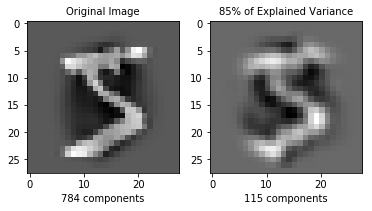

In [15]:


# Applying PCA to train data
pca = PCA(0.85)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 85 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('85% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [16]:
print(reduced_test_data.shape)

(10000, 46)


In [17]:
x = reduced_data
y = label
X_tr = reduced_data
Y_tr = label

In [ ]:
#Calculation of time for Bagging

In [18]:
start_time = time.time()
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=200, oob_score=True, max_samples=0.8, random_state=42)
bagging = bag.fit(X_tr, Y_tr)

In [19]:
X_test = reduced_test_data
predictionsY_test = bagging.predict(X_test)
print("Total time consumed is %s seconds : " % (time.time() - start_time))

Total time consumed is 712.0754270553589 seconds : 


In [20]:
error = 1 - bagging.oob_score_
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  95.38 %
Error Percentage      :  4.62 %


In [21]:
display(predictionsY_test)

array([7., 2., 1., ..., 4., 5., 6.])

In [ ]:
#Calculation of time for RF

In [22]:
start_time = time.time()
clf = RandomForestClassifier(n_estimators=200,warm_start = True, oob_score =True, random_state = 42, 
                             max_features="sqrt")
clf = clf.fit(X_tr, Y_tr)

X_test = reduced_test_data
predictionsY_test = clf.predict(X_test)
print("Total time consumed is %s seconds : " % (time.time() - start_time))

Total time consumed is 85.26480388641357 seconds : 


In [23]:
error = 1 - clf.oob_score_
accuracy = 1 - error

print("Accuracy Percentage   : ",(round(accuracy, 4) *100), "%")
print("Error Percentage      : ",(round(error, 4) *100), "%")

Accuracy Percentage   :  97.04 %
Error Percentage      :  2.96 %


In [24]:
display(predictionsY_test)

array([7., 2., 1., ..., 4., 5., 6.])